In [1]:
import pandas as pd
import pysam
import numpy as np
import akita_utils
import h5py

from akita_utils.utils import ut_dense

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from akita_utils.stats_utils import calculate_SCD

In [3]:
def plot_map(matrix, vmin=-0.6, vmax=0.6, width=5, height=5, palette="RdBu_r"):

    """
    Plots a 512x512 map representating changes in the DNA contacts.

    Parameters
    ------------
    matrix : numpy array
        Changes in DNA contacts.
    vmin : float
    vmax : float
        Minimum and maximum in the colormap scale.
    width : int
    height : int
        Width and height of a plotted map.
    """

    fig = plt.figure(figsize=(width, height))

    sns.heatmap(
        matrix,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        cmap=palette,
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    plt.show()


In [4]:
def get_bin(
    window_start,
    window_end,
    map_size=512,
    bin_size=2048,
    input_size=1310720,
):

    """
    Returns a list of bins overlapping the given window.

    Parameters
    ------------
    window_start : int
    window_end : int
        Start and end of the window that overlapping bins we want to find.
        Note, those values are in the local coordinates, so between 0 and input_size.
    map_size : int
        Size of the maps (equivalent to number of bins).
    bin_size : int
        The length of each bin in base pairs (bp).
    input_size : int
        Length of model's input sequence.

    Returns
    ---------
    bin_index : int
        The bin overlapping the given window.
    """

    window_size = window_end - window_start

    size_after_cropping = map_size * bin_size
    size_difference = input_size - size_after_cropping
    one_side_cropped_length = size_difference // 2

    corrected_window_start = window_start - one_side_cropped_length
    corrected_window_end = window_end - one_side_cropped_length

    first_bin_covered = corrected_window_start // bin_size
    last_bin_covered = corrected_window_end // bin_size
    
    assert first_bin_covered == last_bin_covered
    
    return first_bin_covered
    

In [5]:
def get_insertion_start_pos(insert_bp, spacer_bp, num_inserts, seq_length = 1310720):

    insert_plus_spacer_bp = insert_bp + 2 * spacer_bp
    multi_insert_bp = num_inserts * insert_plus_spacer_bp
    insert_start_bp = seq_length // 2 - multi_insert_bp // 2

    insertion_starting_positions = []
    for i in range(num_inserts):
        offset = insert_start_bp + i * insert_plus_spacer_bp + spacer_bp
        insertion_starting_positions.append(offset)
        
    return insertion_starting_positions

In [6]:
def get_map_matrix(hf, num_sequences, head_index, model_index, num_background):
    """averaged over targets"""
    
    num_targets = 6
    if head_index != 1:
        num_targets = 5
    
    map_size = np.array(hf[f"e0_h{head_index}_m{model_index}_t0_b0"]).shape[0]
    
    map_matrix = np.zeros((map_size, map_size, num_sequences, num_background))

    for seq_index in range(num_sequences):
        for target_index in range(num_targets):
            for background_index in range(num_background):
                map_matrix[:, :, seq_index, background_index] += np.array(hf[f"e{seq_index}_h{head_index}_m{model_index}_t{target_index}_b{background_index}"])
    
    map_matrix = map_matrix / num_targets
    return map_matrix

In [7]:
def get_reference_matrix(hf, head_index, model_index, num_background):
        
    num_targets = 6
    if head_index != 1:
        num_targets = 5
        
    map_size = np.array(hf[f"ref0_h{head_index}_m{model_index}_t0"]).shape[0]
    
    ref_map_matrix = np.zeros((map_size, map_size, num_background))
    
    for target_index in range(num_targets):
        for background_index in range(num_background):
            ref_map_matrix[:, :, background_index] += np.array(hf[f"ref{background_index}_h{head_index}_m{model_index}_t{target_index}"])
    
    ref_map_matrix = ref_map_matrix / num_targets
    return ref_map_matrix



# Reading tsv & getting the reference map-matrix

In [8]:
tsv_filepath = "/home1/smaruj/akita_utils/bin/insert_virtual_dots_vs_boundaries/boundaries_10k.tsv"
df = pd.read_table(tsv_filepath, sep="\t")

In [9]:
seq_id = []

nr_targets = 6
nr_sites = 1000
nr_backgrounds = 10
# since there are 1000 motifs and 10 backgrounds

for background_index in range(nr_backgrounds):
    for seq_index in range(nr_sites):
        seq_id.append(seq_index)


In [10]:
df["seq_id"] = seq_id

In [11]:
df

,chrom,start,end,strand,genomic_SCD,orientation,background_index,flank_bp,spacer_bp,seq_id
0,chr12,35192361,35192380,+,53.780,<>,0,20,99980,0
1,chr2,48886252,48886271,-,53.700,<>,0,20,99980,1
2,chr12,35192359,35192378,-,53.660,<>,0,20,99980,2
3,chr8,102781112,102781131,-,53.500,<>,0,20,99980,3
4,chr5,49961991,49962010,-,53.300,<>,0,20,99980,4
...,...,...,...,...,...,...,...,...,...,...
9995,chr2,118246115,118246134,-,4.390,<>,9,20,99980,995
9996,chr5,117502801,117502820,+,4.367,<>,9,20,99980,996
9997,chr15,76198798,76198817,+,4.363,<>,9,20,99980,997
9998,chr5,143315378,143315397,-,4.360,<>,9,20,99980,998


In [12]:
file_name = "OUT.h5"
out_dir = "/project/fudenber_735/data/dots_vs_boundaries/boundaries_10Kmotifs"
num_procs = 10

In [13]:
one_hf = h5py.File("/project/fudenber_735/data/dots_vs_boundaries/boundaries_10Kmotifs/job0/OUT.h5","r")

In [14]:
head_index, model_index, num_background = 1, 0, 10

In [15]:
reference_matrix = get_reference_matrix(one_hf, head_index, model_index, num_background)

In [16]:
reference_matrix.shape

(512, 512, 10)

# calculating SCD

In [17]:
SCD = np.zeros((nr_sites*nr_backgrounds, nr_targets))

In [18]:
for pi in range(num_procs):
    print("reading ", pi)
    # open job
    job_h5_file = "%s/job%d/%s" % (out_dir, pi, file_name)
    job_h5_open = h5py.File(job_h5_file, "r")

    # append to final
    for key in job_h5_open.keys():
        
        if (key[0] == "e" and key != "end"):
                
            identifiers = key.split("_")
            sequence_id = int(identifiers[0][1:])
            target_id = int(identifiers[3][1:])
            background_id = int(identifiers[4][1:])
            
            exp_index = nr_sites * background_id + sequence_id
            
            map_matrix = np.array(job_h5_open[key])
            
            SCDscore = calculate_SCD(map_matrix, reference_map_matrix=reference_matrix[:, :, background_index])
            
            SCD[exp_index, target_id] += SCDscore
            
    job_h5_open.close()
    

reading  0
reading  1
reading  2
reading  3
reading  4
reading  5
reading  6
reading  7
reading  8
reading  9


In [19]:
for target_index in range(nr_targets):
    df[f"SCD_t{target_index}"] = SCD[:, target_index]

In [20]:
df["SCD_avg"] = df[["SCD_t0", "SCD_t1", "SCD_t2", "SCD_t3", "SCD_t4", "SCD_t5"]].mean(axis=1)

In [21]:
df

,chrom,start,end,strand,genomic_SCD,orientation,background_index,flank_bp,spacer_bp,seq_id,SCD_t0,SCD_t1,SCD_t2,SCD_t3,SCD_t4,SCD_t5,SCD_avg
0,chr12,35192361,35192380,+,53.780,<>,0,20,99980,0,46.479378,55.633564,55.942940,52.129254,53.433813,43.666243,51.214199
1,chr2,48886252,48886271,-,53.700,<>,0,20,99980,1,70.354902,84.831386,71.257677,68.837622,74.734627,60.604679,71.770149
2,chr12,35192359,35192378,-,53.660,<>,0,20,99980,2,87.111106,108.342193,107.249755,105.717226,105.626587,86.544949,100.098636
3,chr8,102781112,102781131,-,53.500,<>,0,20,99980,3,65.666436,78.521517,63.084304,60.607845,67.481686,54.728247,65.015006
4,chr5,49961991,49962010,-,53.300,<>,0,20,99980,4,69.735752,84.818378,73.452009,71.013533,76.132290,61.729778,72.813623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,chr2,118246115,118246134,-,4.390,<>,9,20,99980,995,17.948456,22.493528,22.803442,23.235515,20.006331,14.673002,20.193379
9996,chr5,117502801,117502820,+,4.367,<>,9,20,99980,996,25.374408,32.104273,29.823038,27.572046,29.665844,22.177847,27.786243
9997,chr15,76198798,76198817,+,4.363,<>,9,20,99980,997,14.625047,19.664568,17.670218,20.865982,12.179391,8.512992,15.586366
9998,chr5,143315378,143315397,-,4.360,<>,9,20,99980,998,20.836773,25.982899,24.797115,24.360072,23.150547,17.078197,22.700934


# dot scores

In [22]:
starts = get_insertion_start_pos(insert_bp=59, spacer_bp=99980, num_inserts=2)

In [23]:
insert_bp=59
row_line, col_line = get_bin(starts[0], starts[0]+insert_bp), get_bin(starts[1], starts[1]+insert_bp)

In [24]:
row_line, col_line

(207, 304)

In [25]:
def sum_squares(map_fragment):
    
    return np.sqrt((map_fragment**2).sum(axis=(0,1))) * (1/2)

In [26]:
def get_lines(row_line, col_line, dot_band_size):
    
    upper_horizontal = row_line - (dot_band_size//2)
    lower_horizontal = row_line + (dot_band_size//2)
    if (dot_band_size % 2) == 1:
        lower_horizontal += 1
    
    left_vertical = col_line - (dot_band_size//2)
    right_vertical = col_line + (dot_band_size//2)
    if (dot_band_size % 2) == 1:
        right_vertical += 1
        
    return upper_horizontal, lower_horizontal, left_vertical, right_vertical

In [27]:
def dot_score(map_matrix, row_line, col_line, dot_band_size=3):
    
    upper_horizontal, lower_horizontal, left_vertical, right_vertical = get_lines(row_line, col_line, dot_band_size)
        
    # central, dot part
    dot_score = sum_squares(map_matrix[upper_horizontal:lower_horizontal, left_vertical:right_vertical])
    return dot_score

In [28]:
def dot_x_score(map_matrix, row_line, col_line, dot_band_size=3, boundary_band_size=10):
    
    upper_horizontal, lower_horizontal, left_vertical, right_vertical = get_lines(row_line, col_line, dot_band_size)
    
    # central, dot part
    dot_score = sum_squares(map_matrix[upper_horizontal:lower_horizontal, left_vertical:right_vertical])
        
    # x-parts
    x_score = 0
    for matrix_part in [map_matrix[upper_horizontal - boundary_band_size: upper_horizontal, left_vertical-boundary_band_size: left_vertical], 
                        map_matrix[upper_horizontal - boundary_band_size: upper_horizontal, right_vertical: right_vertical+boundary_band_size], 
                        map_matrix[lower_horizontal: lower_horizontal+boundary_band_size, left_vertical-boundary_band_size: left_vertical], 
                        map_matrix[lower_horizontal: lower_horizontal+boundary_band_size, right_vertical: right_vertical+boundary_band_size]]:
        x_score += sum_squares(matrix_part)
    
    if x_score == 0:
        return 0.0
    return dot_score / x_score

In [29]:
def dot_score_cross(map_matrix, row_line, col_line, dot_band_size=3, boundary_band_size=10):
    
    upper_horizontal, lower_horizontal, left_vertical, right_vertical = get_lines(row_line, col_line, dot_band_size)
    
    # central, dot part
    dot_score = sum_squares(map_matrix[upper_horizontal:lower_horizontal, left_vertical:right_vertical])
    
    # cross-parts
    cross_score = 0
    for matrix_part in [map_matrix[upper_horizontal - boundary_band_size: upper_horizontal, left_vertical:right_vertical], 
                        map_matrix[upper_horizontal:lower_horizontal, left_vertical-boundary_band_size: left_vertical], 
                        map_matrix[upper_horizontal:lower_horizontal, right_vertical: right_vertical+boundary_band_size], 
                        map_matrix[lower_horizontal: lower_horizontal+boundary_band_size, left_vertical:right_vertical]]:
        cross_score += sum_squares(matrix_part)
    
    if cross_score == 0:
        return 0.0
    return dot_score / cross_score

# adding dot-score to the df

In [30]:
out_dir = "/project/fudenber_735/data/dots_vs_boundaries/dots_10Kmotifs"

In [31]:
dots = np.zeros((nr_sites*nr_backgrounds, nr_targets))
x_score = np.zeros((nr_sites*nr_backgrounds, nr_targets))
cross_score = np.zeros((nr_sites*nr_backgrounds, nr_targets))

In [ ]:
# pi = 0

# job_h5_file = "%s/job%d/%s" % (out_dir, pi, file_name)
# job_h5_open = h5py.File(job_h5_file, "r")

# k = 0

# for key in job_h5_open.keys():
    
#     if k < 25:
        
#         if (key[0] == "e" and key != "end"):
            
#             print(key)
            
#             identifiers = key.split("_")
#             sequence_id = int(identifiers[0][1:])
#             target_id = int(identifiers[3][1:])
#             background_id = int(identifiers[4][1:])

#             exp_index = nr_sites * background_id + sequence_id

#             map_matrix = np.array(job_h5_open[key])
            
#             plot_map(map_matrix)
            
#             dot = dot_score(map_matrix, row_line=row_line, col_line=col_line)
#             x = dot_x_score(map_matrix, row_line=row_line, col_line=col_line)
#             cross = dot_score_cross(map_matrix, row_line=row_line, col_line=col_line)

#             print("dot score: ", dot)
#             print("x score: ", x)
#             print("cross score: ", cross)
            
#             # dots[exp_index, target_id] += dot
#             # x_score[exp_index, target_id] += x
#             # cross_score[exp_index, target_id] += cross
#     k += 1
    
# job_h5_open.close()


In [ ]:
# job_h5_file = "%s/job%d/%s" % (out_dir, pi, file_name)
# job_h5_open = h5py.File(job_h5_file, "r")

# dot_map = np.array(job_h5_open["e100_h1_m0_t1_b0"])
# no_dot = np.array(job_h5_open["e100_h1_m0_t3_b0"])

# job_h5_open.close()

In [ ]:
# plot_map(dot_map)

In [ ]:
# plot_map(no_dot)

In [32]:
for pi in range(num_procs):
    print("reading ", pi)
    # open job
    job_h5_file = "%s/job%d/%s" % (out_dir, pi, file_name)
    job_h5_open = h5py.File(job_h5_file, "r")

    # append to final
    for key in job_h5_open.keys():
        
        if (key[0] == "e" and key != "end"):
                
            identifiers = key.split("_")
            sequence_id = int(identifiers[0][1:])
            target_id = int(identifiers[3][1:])
            background_id = int(identifiers[4][1:])
            
            exp_index = nr_sites * background_id + sequence_id
            
            map_matrix = np.array(job_h5_open[key])
            
            dot = dot_score(map_matrix, row_line=row_line, col_line=col_line)
            x = dot_x_score(map_matrix, row_line=row_line, col_line=col_line)
            cross = dot_score_cross(map_matrix, row_line=row_line, col_line=col_line)
            
            dots[exp_index, target_id] += dot
            x_score[exp_index, target_id] += x
            cross_score[exp_index, target_id] += cross
            
    job_h5_open.close()

reading  0
reading  1
reading  2
reading  3
reading  4
reading  5
reading  6
reading  7
reading  8
reading  9


In [33]:
for target_index in range(nr_targets):
    df[f"dot_t{target_index}"] = dots[:, target_index]
    df[f"x_score_t{target_index}"] = x_score[:, target_index]
    df[f"cross_t{target_index}"] = cross_score[:, target_index]

In [35]:
df["dot_avg"] = df[["dot_t0", "dot_t1", "dot_t2", "dot_t3", "dot_t4", "dot_t5"]].mean(axis=1)
df["x_score_avg"] = df[["x_score_t0", "x_score_t1", "x_score_t2", "x_score_t3", "x_score_t4", "x_score_t5"]].mean(axis=1)
df["cross_avg"] = df[["cross_t0", "cross_t1", "cross_t2", "cross_t3", "cross_t4", "cross_t5"]].mean(axis=1)

In [36]:
df

,chrom,start,end,strand,genomic_SCD,orientation,background_index,flank_bp,spacer_bp,seq_id,...,cross_t3,dot_t4,x_score_t4,cross_t4,dot_t5,x_score_t5,cross_t5,dot_avg,x_score_avg,cross_avg
0,chr12,35192361,35192380,+,53.780,<>,0,20,99980,0,...,0.147920,1.129883,0.079160,0.139230,1.005859,0.082374,0.143314,1.089518,0.080663,0.140427
1,chr2,48886252,48886271,-,53.700,<>,0,20,99980,1,...,0.302614,1.150391,0.268123,0.261661,0.990723,0.270569,0.259264,1.229818,0.277454,0.266258
2,chr12,35192359,35192378,-,53.660,<>,0,20,99980,2,...,0.258080,1.497070,0.221628,0.238340,1.308594,0.223408,0.236373,1.568848,0.230070,0.241119
3,chr8,102781112,102781131,-,53.500,<>,0,20,99980,3,...,0.293663,1.212891,0.258239,0.256665,1.051758,0.260649,0.254249,1.295654,0.267695,0.260932
4,chr5,49961991,49962010,-,53.300,<>,0,20,99980,4,...,0.290465,1.218750,0.257638,0.256000,1.053711,0.259219,0.253524,1.295980,0.267439,0.259832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,chr2,118246115,118246134,-,4.390,<>,9,20,99980,995,...,0.131501,0.108582,0.040388,0.088525,0.119080,0.044625,0.094580,0.246114,0.139610,0.168376
9996,chr5,117502801,117502820,+,4.367,<>,9,20,99980,996,...,0.072135,0.210571,0.121805,0.356626,0.164429,0.092273,0.293464,0.408091,0.148162,0.221998
9997,chr15,76198798,76198817,+,4.363,<>,9,20,99980,997,...,0.123578,0.200806,0.067044,0.119776,0.205200,0.069302,0.122433,0.165220,0.053266,0.097943
9998,chr5,143315378,143315397,-,4.360,<>,9,20,99980,998,...,0.107575,0.049805,0.022025,0.058020,0.036041,0.015427,0.039991,0.317062,0.139101,0.149039


<AxesSubplot:xlabel='SCD_avg', ylabel='dot_avg'>

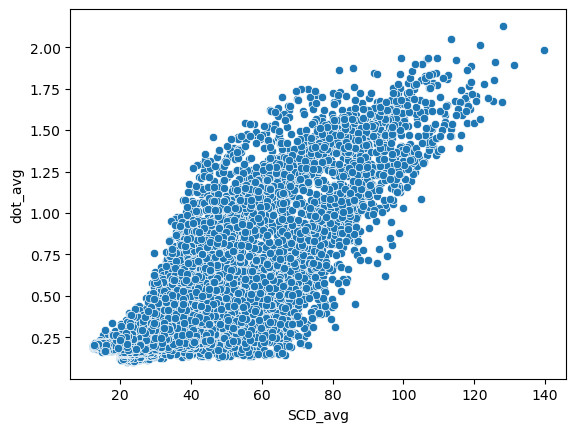

In [37]:
sns.scatterplot(data=df, x="SCD_avg", y="dot_avg")

<AxesSubplot:xlabel='SCD_avg', ylabel='x_score_avg'>

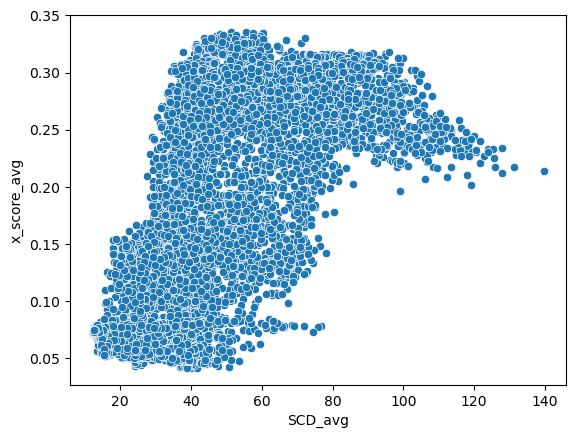

In [38]:
sns.scatterplot(data=df, x="SCD_avg", y="x_score_avg")

<AxesSubplot:xlabel='SCD_avg', ylabel='cross_avg'>

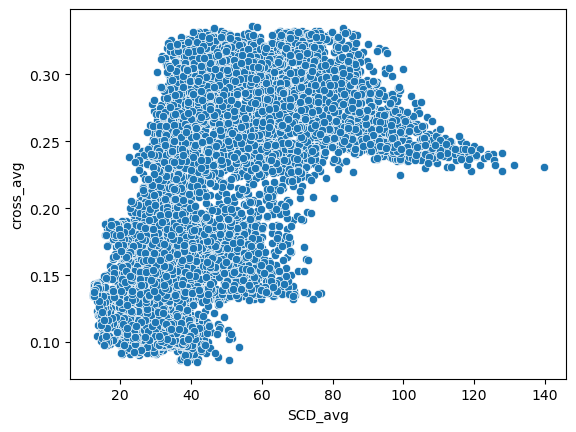

In [39]:
sns.scatterplot(data=df, x="SCD_avg", y="cross_avg")

In [ ]:
hf = h5py.File("/project/fudenber_735/data/dots_vs_boundaries/boundaries_10Kmotifs/job0/OUT.h5","r")

In [ ]:
hf = h5py.File("/project/fudenber_735/data/dots_vs_boundaries/boundaries_10Kmotifs/job0/OUT.h5","r")

columns_to_df = []

for key in hf:
    if (key[0] != "e" and key[:3] != "ref"):
        columns_to_df.append(key)

In [ ]:
columns_to_df

In [ ]:
hf = h5py.File("/project/fudenber_735/data/dots_vs_boundaries/boundaries_10Kmotifs/job2/OUT.h5","r")

columns_to_df = []

i = 0

for key in hf:
    if (key[0] == "e" and key[:3] != "ref"):
        if i < 10:
            print(key)
    i += 1


In [ ]:
example = "e0_h1_m0_t1_b2"

In [ ]:
identifiers = example.split("_")

In [ ]:
sequence_id = identifiers[0][1]

In [ ]:
target_id = identifiers[3][1]

In [ ]:
target_id

In [ ]:
background_id = identifiers[4][1]

In [ ]:
background_id